Try out a model that is only trained on the similarity label (one hot encoded).

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


## read in data

In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [4]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [5]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [6]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

## create sequences

In [7]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [18]:
census_enum_seq.df

,block_num,CD_ADDRESS,cd_X,cd_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,num_between,sequence_order_enum,dist,sequence_len,fixed_seq,dwelling_seq_id,enum_dist_id,enum_dist_order,enum_dist,enum_sequence_len
0,NaN,NaN,NaN,NaN,16,4610,1.0,1.0,1,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,50,4610,1.0,2.0,10,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,35,4610,1.0,2.0,10,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,21,4610,1.0,2.0,10,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,24,4610,1.0,2.0,10,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23096,NaN,NaN,NaN,NaN,30,4610,930.0,2062.0,6,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,48,1043.0,NaN,NaN,NaN,NaN
23097,NaN,NaN,NaN,NaN,5,4610,930.0,2062.0,6,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,48,1043.0,NaN,NaN,NaN,NaN
23098,NaN,NaN,NaN,NaN,3,4610,930.0,2062.0,6,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,48,1043.0,NaN,NaN,NaN,NaN
23099,NaN,NaN,NaN,NaN,0,4610,930.0,2062.0,6,NEW YORK WARD 10,...,NaN,NaN,NaN,NaN,48,1043.0,NaN,NaN,NaN,NaN


In [22]:
census_enum_seq.df[["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]].apply(lambda x: len(x.unique()))

sequence_id        170
dwelling_seq_id      2
fixed_seq           49
enum_dist_id       164
dtype: int64

In [21]:
census_enum_seq.df['sequence_id'].unique()

array([  nan,   38.,   41.,   64.,   65.,   69.,   74.,  105.,  127.,
        133.,  140.,  142.,  152.,  155.,  159.,  161.,  172.,  190.,
        196.,  204.,  219.,  221.,  230.,  239.,  258.,  260.,  273.,
        298.,  299.,  323.,  330.,  331.,  341.,  372.,  373.,  375.,
        385.,  389.,  423.,  428.,  448.,  465.,  474.,  476.,  491.,
        501.,  502.,  522.,  551.,  557.,  596.,  601.,  620.,  622.,
        668.,  685.,  686.,  687.,  699.,  701.,  705.,  708.,  747.,
        761.,  773.,  776.,  779.,  795.,  799.,  818.,  821.,  831.,
        843.,  851.,  852.,  859.,  871.,  880.,  894.,  900.,  911.,
        929.,  933.,  946.,  947.,  962.,  976.,  978., 1007., 1022.,
       1028., 1050., 1054., 1067., 1069., 1096., 1112., 1121., 1135.,
       1171., 1182., 1206., 1208., 1212., 1224., 1237., 1243., 1256.,
       1261., 1290., 1294., 1311., 1312., 1314., 1316., 1322., 1348.,
       1353., 1374., 1375., 1383., 1384., 1427., 1483., 1497., 1515.,
       1522., 1524.,

## create similarity labels

In [23]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
census_enum_seq.apply_similarity(sim_columns=similar_cols, k=150)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 74, cost: 2812.0
Run 1, iteration: 2/100, moves: 0, cost: 2812.0


In [27]:
census_enum_seq.df['similarity_label'].value_counts()

29     511
2      492
24     478
5      457
21     456
      ... 
120      7
118      6
122      6
129      5
145      3
Name: similarity_label, Length: 150, dtype: int64

In [28]:
census_enum_seq.df.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'dwelling_id', 'spatial_weight', 'spatial_weight_sum',
       'CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_PAGENNO', 'CENSUS_WARD_NUM',
       'CENSUS_REEL_HOUSEHOLD', 'CENSUS_ENUMERATOR_NUM',
       'CENSUS_ENUMERATOR_DATE', 'ANCESTRY_REF', 'sequence_id', 'num_between',
       'sequence_order_enum', 'dist', 'sequence_len', 'fixed_seq',
       'dwelling_seq_id', 'enum_dist_id', 'enum_dist_order', 'enum_dist',
       'enum_sequence_len', 'similarity_label'],
      dtype='object

## preprocessing

only on sequences

* This could be a problem. There are sim labels that never appear in the training set but only on test set. Thus, it can't be applied.

In [29]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

# transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
#                                               ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])

transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])

# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration


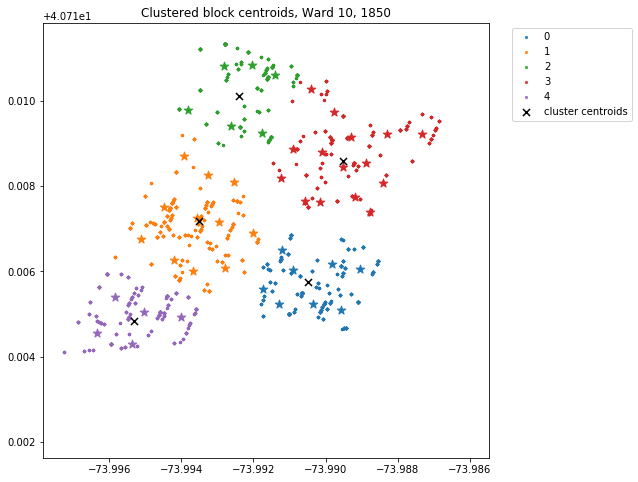

In [30]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [61]:
summary_df = interpolate_sequences.df[['similarity_label', 'cluster', 'block_num']]
cnt = summary_df.groupby(['similarity_label', 'cluster'], as_index=False)['block_num'].agg('count')
total = summary_df.groupby('similarity_label', as_index=False)['block_num'].agg('count')
summary_df = cnt.merge(total, on='similarity_label', how='left')
summary_df['membership'] = summary_df['block_num_x']/summary_df['block_num_y']*100
summary_df.drop(columns=['block_num_x', 'block_num_y'], inplace=True)
summary_df = summary_df.pivot_table(index='similarity_label', columns='cluster', values='membership')
summary_df.fillna('0', inplace=True)
summary_df.reset_index(inplace=True)
summary_df = summary_df.merge(total, on='similarity_label', how='left')
summary_df.rename(columns={'block_num': 'count'}, inplace=True)
summary_df.to_csv('../../membership_table_1.csv', index=False)

In [65]:
temp = interpolate_sequences.df[['similarity_label', 'cluster', 'block_num']]
temp.loc[temp['similarity_label']==0]

,similarity_label,cluster,block_num


In [73]:
temp = census_enum_seq.df[['similarity_label','block_num']]
temp.loc[temp['similarity_label'] == 0]['block_num']
# temp.groupby('similarity_label')['block_num'].agg('count')

1193   NaN
1194   NaN
1195   NaN
1196   NaN
1197   NaN
        ..
1753   NaN
1754   NaN
1755   NaN
1756   NaN
1757   NaN
Name: block_num, Length: 436, dtype: float64

In [71]:
census_enum_seq.df.shape

(23101, 51)

In [66]:
interpolate_sequences.df.shape

(5833, 52)

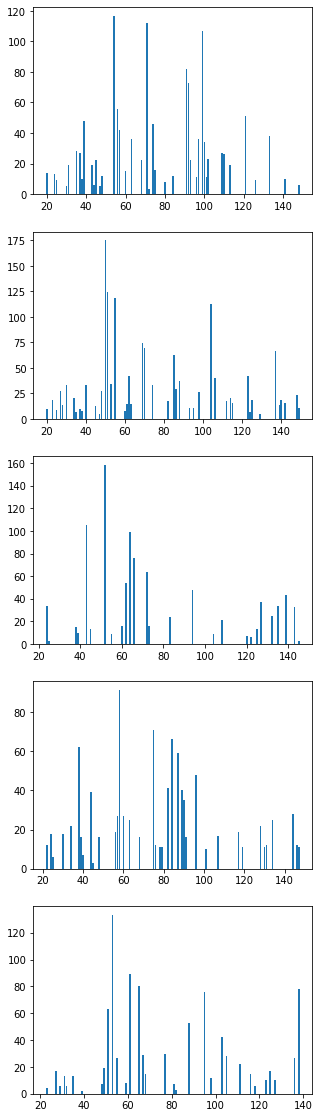

In [36]:
fig, ax = plt.subplots(5, 1,figsize=(5, 20))
for i in range(5):
    temp = interpolate_sequences.df.loc[interpolate_sequences.df['cluster'] == i]['similarity_label']
    temp = temp.value_counts()
    temp.sort_values(inplace=True)
    ax[i].bar(temp.index, temp.values)

In [31]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.8256987233988511
Test score: [0.6584887144259077, 0.6198979591836735, 0.5135363790186125, 0.6081668114682884, 0.6488609583660644, 0.6441281138790036, 0.6867061812023709, 0.7021466905187835, 0.6677577741407529, 0.6551418439716312]
avg Test score: 0.6404831426175089


## preprocessing

same setting + 150 similarity labels

In [37]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])

# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration


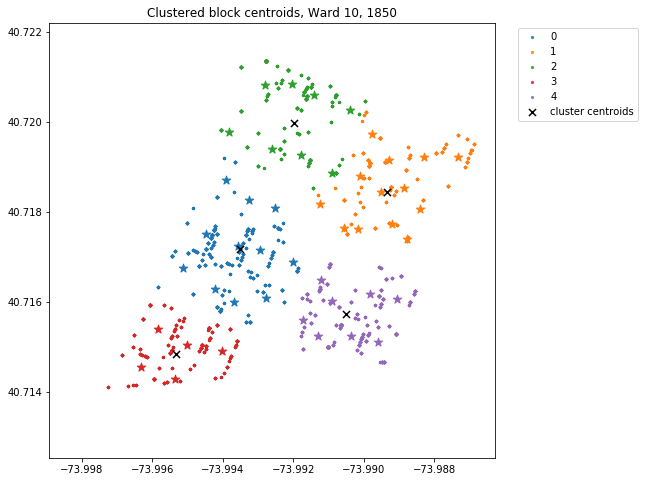

In [38]:
interpolate_sequences_all = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences_all.kmeans_best(5)
interpolate_sequences_all.set_clustering_algo(model)
interpolate_sequences_all.apply_clustering(algo_fit = True)
interpolate_sequences_all.clustervis(kmeans = True)

In [39]:
## retrain model using kmodes result

interpolate_sequences_all.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences_all.train_score).mean())
print('Test score:', interpolate_sequences_all.test_score)
print("avg Test score:", np.array(interpolate_sequences_all.test_score).mean())

Cross Validation
avg Training score: 0.9825292413798941
Test score: [0.6398026315789473, 0.6020066889632107, 0.689802913453299, 0.633249791144528, 0.597691673536686, 0.5547765118317266, 0.6493955094991365, 0.6993699369936993, 0.588021778584392, 0.5637130801687764]
avg Test score: 0.6217830515754401


# ==========

## Train and test the model

In [11]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [12]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.9845338046840477
Test score: 0.5332823259372609


In [13]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [14]:
test

,block_num,CD_ADDRESS,cd_X,cd_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,sequence_len,fixed_seq,dwelling_seq_id,enum_dist_id,enum_dist_order,enum_dist,enum_sequence_len,similarity_label,cluster,pred_cluster
359,198.0,122 Forsyth,-73.992273,40.719295,36,4610,42.0,69.0,3,NEW YORK WARD 10,...,23.0,1,0.0,41,0.0,0.368425,23.0,0,1,2
360,198.0,122 Forsyth,-73.992273,40.719295,35,4610,42.0,69.0,3,NEW YORK WARD 10,...,23.0,1,0.0,41,0.0,0.368425,23.0,0,1,2
361,198.0,122 Forsyth,-73.992273,40.719295,5,4610,42.0,69.0,3,NEW YORK WARD 10,...,23.0,1,0.0,41,0.0,0.368425,23.0,0,1,2
362,198.0,122 Forsyth,-73.992273,40.719295,33,4610,42.0,70.0,5,NEW YORK WARD 10,...,23.0,1,0.0,41,0.0,0.368425,23.0,0,1,2
363,198.0,122 Forsyth,-73.992273,40.719295,25,4610,42.0,70.0,5,NEW YORK WARD 10,...,23.0,1,0.0,41,0.0,0.368425,23.0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22202,1268.0,79 Hester,-73.991170,40.716039,8,4610,860.0,1897.0,7,NEW YORK WARD 10,...,28.0,46,1043.0,1922,2.0,0.031715,28.0,1,0,0
22203,1268.0,79 Hester,-73.991170,40.716039,7,4610,860.0,1897.0,7,NEW YORK WARD 10,...,28.0,46,1043.0,1922,2.0,0.031715,28.0,1,0,0
22204,1268.0,79 Hester,-73.991170,40.716039,5,4610,860.0,1897.0,7,NEW YORK WARD 10,...,28.0,46,1043.0,1922,2.0,0.031715,28.0,1,0,0
22205,1268.0,79 Hester,-73.991170,40.716039,1,4610,860.0,1897.0,7,NEW YORK WARD 10,...,28.0,46,1043.0,1922,2.0,0.031715,28.0,1,0,0
